# Assignment 6 - Natural Computing
## Swarm Intelligence 
### Group 25
#### Boids model & Sequential ABC algorithm

This notebook presents an agent-based model that simulates the flocking behavior of animals (Boids model).
Then the sequential ABC algorithm is applied so as to find the best parameters for the target alignment.

In [1]:
!pip install -q agentpy

import agentpy as ap
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import IPython
import seaborn as sns
global PATH
PATH = '/data/notebook_files/'


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Model definition

The Boids model is based on two classes, one for the agents, and one for the overall model.
For more information about this structure, take a look at the [creating models](https://agentpy.readthedocs.io/en/latest/overview.html#creating-models).

Each agent starts with a random position and velocity, which are implemented as numpy [arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html).
The position is defined through the space environment,
which the agent can access via `Agent.position()` and `Agent.neighbors()`.

The methods `update_velocity()` and `update_position()` are separated so that all agents can
update their velocity before the actual movement takes place.
For more information about the algorithm in `update_velocity()`,
check out the [Boids Pseudocode](http://www.vergenet.net/~conrad/boids/pseudocode.html).

In [2]:
def normalize(v):
    """ Normalize a vector to length 1. """
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [3]:
def order_parameter(boids):
  """Order parameter over time
  Avg normalized velocity of the Boids"""
  velocities = [normalize(boid.velocity) for boid in boids.agents]
  sum_normalized_velocities = np.sum(velocities, axis=0)

  norm = np.linalg.norm(sum_normalized_velocities)
  o = norm / len(boids.agents)
  return o

In [4]:
class Boid(ap.Agent):
    """ An agent with a position and velocity in a continuous space,
    who follows Craig Reynolds three rules of flocking behavior;
    plus a fourth rule to avoid the edges of the simulation space. """

    def setup(self):
        self.velocity = normalize(
            self.model.nprandom.random(self.p.ndim) - 0.5) * self.p.v

    def setup_pos(self, space):

        self.space = space
        self.neighbors = space.neighbors
        self.pos = space.positions[self]

    def update_velocity(self):

        pos = self.pos
        ndim = self.p.ndim

        # Rule 1 - Cohesion
        nbs = self.neighbors(self, distance=self.p.outer_radius)
        nbs_len = len(nbs)
        nbs_pos_array = np.array(nbs.pos)
        nbs_vec_array = np.array(nbs.velocity)
        if nbs_len > 0:
            center = np.sum(nbs_pos_array, 0) / nbs_len
            v1 = (center - pos) * self.p.cohesion_strength
        else:
            v1 = np.zeros(ndim)

        # Rule 2 - Seperation
        v2 = np.zeros(ndim)
        for nb in self.neighbors(self, distance=self.p.inner_radius):
            v2 -= nb.pos - pos
        v2 *= self.p.seperation_strength

        # Rule 3 - Alignment
        if nbs_len > 0:
            average_v = np.sum(nbs_vec_array, 0) / nbs_len
            v3 = (average_v - self.velocity) * self.p.alignment_strength
        else:
            v3 = np.zeros(ndim)

    #    Rule 4 - Borders
        v4 = np.zeros(ndim)
        d = self.p.border_distance
        s = self.p.border_strength
        for i in range(ndim):
            if pos[i] < d:
                v4[i] += s
            elif pos[i] > self.space.shape[i] - d:
                v4[i] -= s
    
        # Update velocity
        self.velocity += v1 + v2 + v3 + v4
        self.velocity = normalize(self.velocity)
        self.velocity *= self.p.v

    def update_position(self):

        self.space.move_by(self, self.velocity)
    
    def calculate_nearest_neighbors(self):
        """ Nearest neighbors distances calculation
        Calculate the euclidean distance of the neighbors' boid 
        meaning the ones that are in the outer radius.
        """
        pos = self.pos
        neighbors = self.neighbors(self, distance=self.p.outer_radius)
        if len(neighbors)> 0:  
            nbs_pos_diff = [np.linalg.norm(n.pos - pos) for n in neighbors]
            closest = np.min(nbs_pos_diff)
        else:
            closest = np.nan

        return closest

In [5]:
def write_file(file_name, text):
    with open(file_name, "a") as file:
        file.write(text)

In [6]:
class BoidsModel(ap.Model):
    """
    An agent-based model of animals' flocking behavior,
    based on Craig Reynolds' Boids Model [1]
    and Conrad Parkers' Boids Pseudocode [2].

    [1] http://www.red3d.com/cwr/boids/
    [2] http://www.vergenet.net/~conrad/boids/pseudocode.html
    """
       
    def setup(self):
        """ Initializes the agents and network of the model. """
        self.space = ap.Space(self, shape=[self.p.size]*self.p.ndim)
        self.agents = ap.AgentList(self, self.p.population, Boid)

        self.space.add_agents(self.agents, random=True)
        self.agents.setup_pos(self.space)
        self.sim_num = self.p.sim_number
        self.nns = []
        self.orders = []
        """Saves the steps and if the nns and 
        order parameter of each step will be saved."""
        self.steps = 0
        self.write = self.p.write


    def step(self):
        """ Defines the models' events per simulation step. """

        self.agents.update_velocity()  # Adjust direction
        self.agents.update_position()  # Move into new direction

        new_o = order_parameter(self) #calculate order parameter
        self.orders.append(new_o)

        new_nns = self.agents.calculate_nearest_neighbors() # calculate nearest neighbors
        self.nns.append(new_nns)
        
        # write the order and nns to a file when it's the last step
        if self.steps == self.p.steps-1 and self.write: 
            nn_text = ''.join([','.join([str(n) for n in nns])+'\n' for nns in self.nns])
            write_file(f"{PATH}nns_{self.sim_num}.txt", nn_text)
            o_text = ''.join([str(o)+'\n' for o in self.orders])
            write_file(f"{PATH}o_{self.sim_num}.txt", o_text)

        self.steps += 1

    
    def end(self):
        # return orders and nns
        self.report('orders', self.orders)
        self.report('nns', self.nns)

## Animation of the simulation

In [36]:

def animation_plot_single(m, ax):
    ndim = m.p.ndim
    ax.set_title(f"Boids Flocking Model {ndim}D t={m.t}")
    pos = m.space.positions.values()
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=4, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    ax.set_axis_off()

    # print the order parameter to the simulation
    o = order_parameter(m)
    x, y = 0.05, 0.95
    ax.text(x, y, f'Order parameter: {round(o,2)}', transform=ax.transAxes)

    

def animation_plot(m,p):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    anim = ap.animate(m(p), fig, ax, animation_plot_single)
    return anim

## Simulation (2D)

To run a simulation, we define a dictionary with our parameters:

In [37]:

def get_pars(simulation_number=1, write=True, coh_strength=0.01, sep_strength=0.1, al_strength=0.5, seed=123):

    return {  
        'size': 50,
        'seed': seed,
        'steps': 300,
        'ndim': 2,
        'population': 15,
        'inner_radius': 3, # exclusion
        'outer_radius': 8,  # interaction
        'cohesion_strength': coh_strength,
        'seperation_strength': sep_strength,
        'alignment_strength': al_strength,
        'border_strength': 0.5,
        'border_distance': 5,
        'sim_number' : simulation_number,
        'write': write,
        'v': 1 #change if you want to adjust speed 
    }

# save a random simulation number if you want to store the order and nns files
random_int = np.random.randint(100, size=1)[0]
print(f"Simulation random number {random_int}")

parameters2D = get_pars(random_int)

Simulation random number 58


We can now display the animation with two dimensions:

In [38]:
anim = animation_plot(BoidsModel, parameters2D)
# save it as gif
# gif = f"{PATH}animation.gif" 
# writergif = PillowWriter(fps=20) 
# anim.save(gif, writer=writergif)

In [39]:
IPython.display.HTML(anim.to_jshtml(fps=30))

Once 
 
 Loop 
 
 Reflect

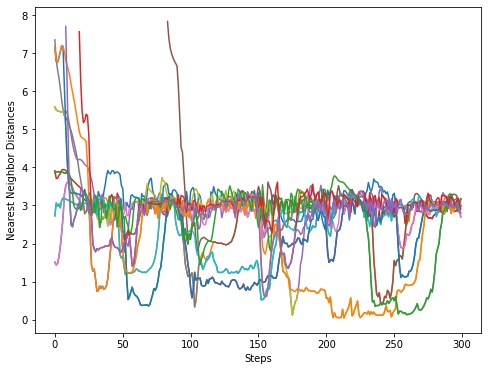

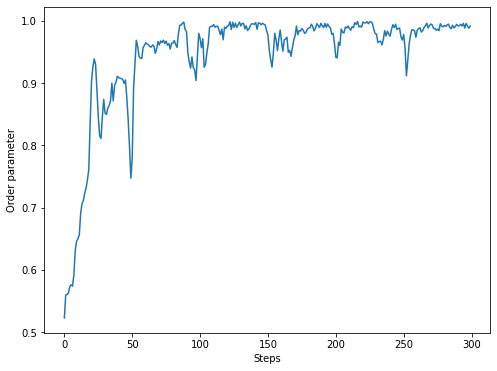

In [45]:
def read_data(filepath):
    with open(filepath) as f:
        lines  = f.readlines()
        array = [line.split(",") for line in lines]
        array = [[float(i) for i in j] for j in array]
    return array

def plot_simulation_nns_order(random_int):
    # plot the nns values
    nns_target = read_data(f"{PATH}nns_{random_int}.txt")
    plt.figure(figsize=(8,6))
    plt.plot(nns_target)
    plt.xlabel('Steps')
    plt.ylabel('Nearest Neighbor Distances')
    plt.savefig(f"{PATH}nns.png")
    plt.show()
    plt.close()

    # plot the order parameter values
    order_target = read_data(f"{PATH}o_{random_int}.txt")
    plt.figure(figsize=(8,6))
    plt.plot(order_target)
    plt.xlabel('Steps')
    plt.ylabel('Order parameter')
    plt.savefig(f"{PATH}order.png")
    plt.show()
    plt.close()

plot_simulation_nns_order(random_int)

## Sequential ABC 
### Target alignment 1.0

In [46]:
def run_experiment(params):
    """
    Run the Boids model with the given params
    Returns the orders
    """
    exp = ap.Experiment(BoidsModel,params)
    results = exp.run(display= False)
    orders = results.reporters.orders[0]
    nns = results.reporters.nns[0]
    return orders, nns

In [47]:
def posterior_sample(sample, target, n_samples = 20, eps = 1, num_steps = 300):
    """Calculate the posterior """
    k = 0
    accepted_params = []
    accepted_orders = []
    while k < n_samples:
        # Draw
        theta = random.choice(sample)
        # Mutate
        mutation = np.random.normal(0,0.1,3)
        theta = theta + mutation

        # if theta values are negative sample again
        while np.min(theta) < 0:
            theta = random.choice(sample)
            mutation = np.random.normal(0,0.1,3)
            theta = theta + mutation
 
        # Accept
        cohesion = theta[0]
        separation = theta[1]
        alignment = theta[2]
  
        parameters = get_pars(write=False, coh_strength=cohesion, sep_strength=separation, al_strength=alignment)

        orders, nns = run_experiment(parameters)
        orders = np.array(orders)
        diff = np.sum(np.abs(orders - target))/num_steps

        # calculate the distance and compare it with epsilon
        if diff < eps:
            accepted_params.append(theta)
            accepted_orders.append(np.mean(orders))
            k += 1
    return accepted_params, accepted_orders

In [48]:
def ABC(target = 1.0, n_samples = 20, iterations= 9, eps = 1.0):
    """Run the sequential ABC- Monte Carlo algorithm"""
    # sample from uniform distribution 3 variables for coh,sep and al
    prior = np.random.uniform(size=(n_samples, 3))

    # store the parameters generated in every loop
    generation_parameters = []
    generation_orders = []
    for generation in range(iterations):
        # calculate posterior 
        prior, orders = posterior_sample(prior, target, n_samples, eps)
        print(f'generation = {generation + 1} #params = {len(prior)}')
        
        generation_parameters.append(prior)
        generation_orders.append(orders)

        # reduce epsilon
        eps -= target/10
    return generation_parameters, generation_orders

In [44]:
gener, order = ABC()

generation = 1 #params = 20
generation = 2 #params = 20
generation = 3 #params = 20
generation = 4 #params = 20
generation = 5 #params = 20
generation = 6 #params = 20
generation = 7 #params = 20
generation = 8 #params = 20
generation = 9 #params = 20


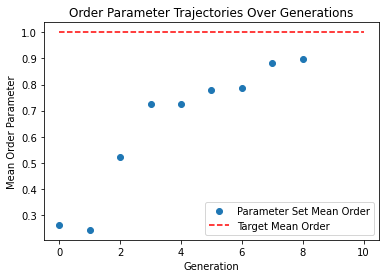

In [49]:
# Plot the mean Order Parameter for every generation
means = [np.mean(sublist) for sublist in order]
plt.scatter(range(len(means)), means, label="Parameter Set Mean Order")
plt.hlines(1.0,0,10, linestyles = 'dashed', colors='red', label='Target Mean Order')

plt.xlabel("Generation")
plt.ylabel("Mean Order Parameter")
plt.title("Order Parameter Trajectories Over Generations")
plt.legend(loc='lower right')
plt.show()

In [50]:
def plot_marginal(num_gen, generation_list, order_parameters, param_max):
    """Plot the marginal distribution of accepted parameter and the order parameters"""
    generation_array = np.array(generation_list[num_gen])
    num_params = generation_array.shape[1]

    parameters = ['Cohesion','Separation', 'Alignment' ]

    fig, axes = plt.subplots(1, num_params + 1, figsize=(15, 5))  # Create subplots for each parameter

    x_lim = [[-0.1, param_max[0]+0.1], [-0.1, param_max[1]+0.1], [-0.1, param_max[2]+0.1]]
    y_lim = [[0, 15], [0, 15], [0, 15]]
    for i in range(num_params):
        sns.histplot(generation_array[:, i], kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f'{parameters[i]} Distribution ')
        axes[i].set_xlabel(f'{parameters[i]} strength')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(x_lim[i])
        axes[i].set_ylim(y_lim[i])
    

    # Visualize distribution of alignment values
    sns.histplot(order_parameters[num_gen], kde=True, color='orange')
    plt.title('Order Distribution')
    plt.xlabel('Order Parameter')
    plt.ylabel('Frequency')
    plt.xlim([0, 1])

    fig.suptitle(f'Parameter and Order Distributions for Generation {num_gen + 1}', fontsize=14)
    plt.tight_layout()

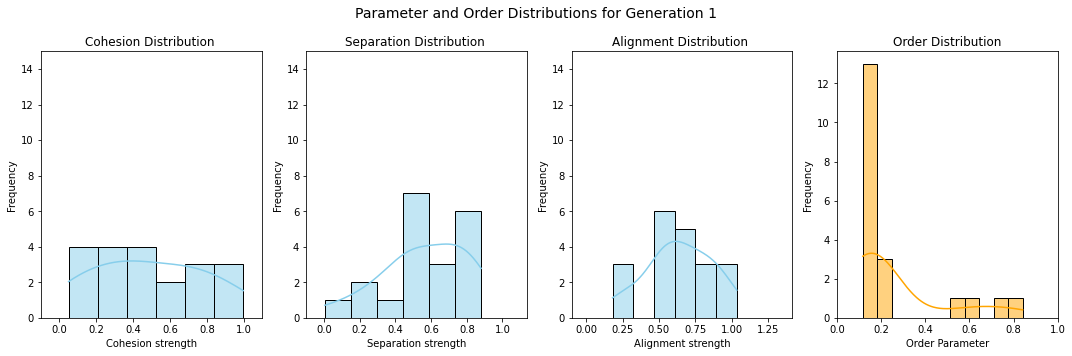

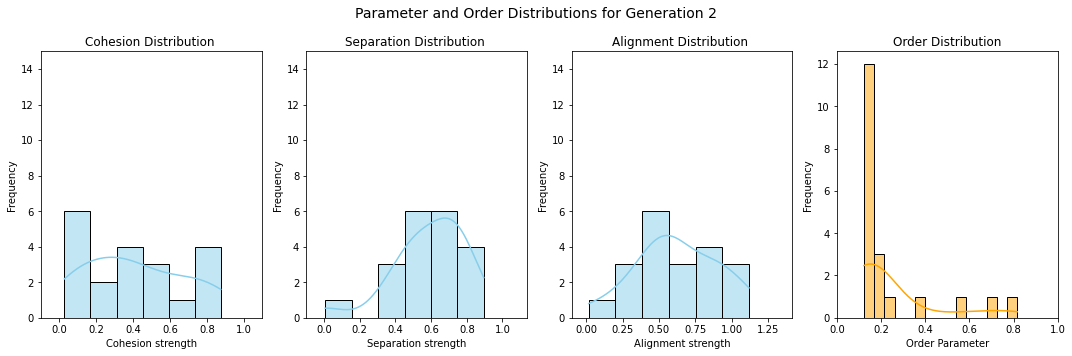

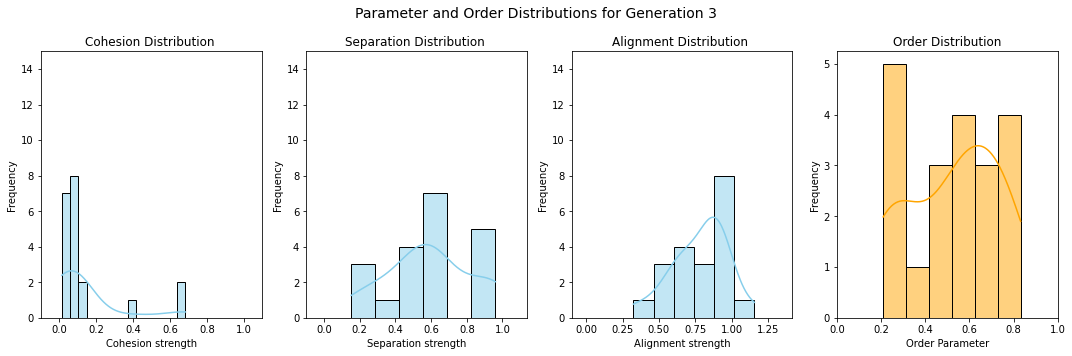

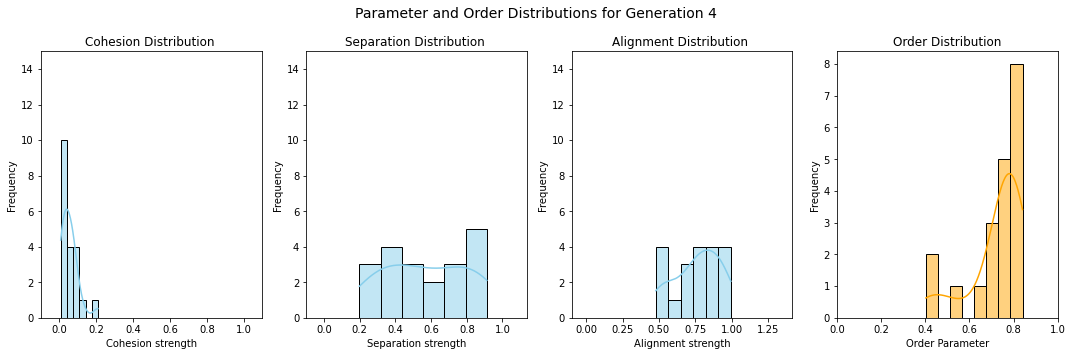

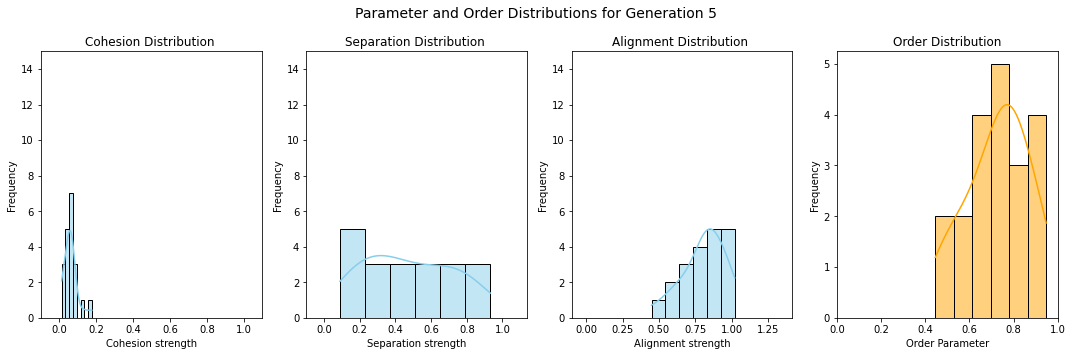

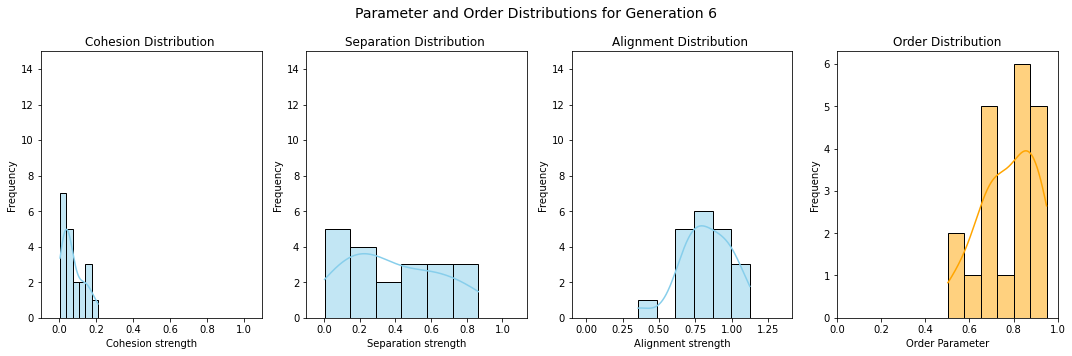

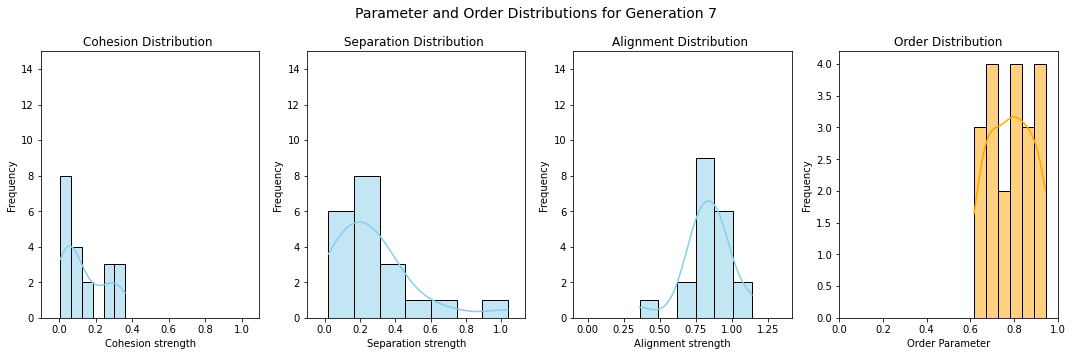

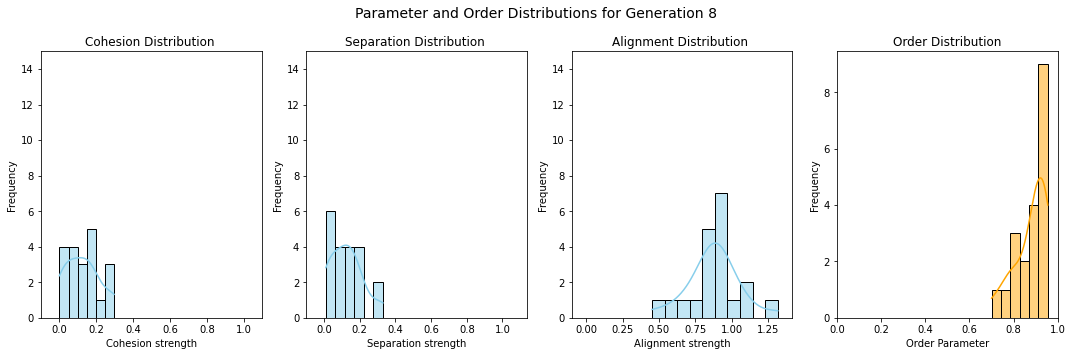

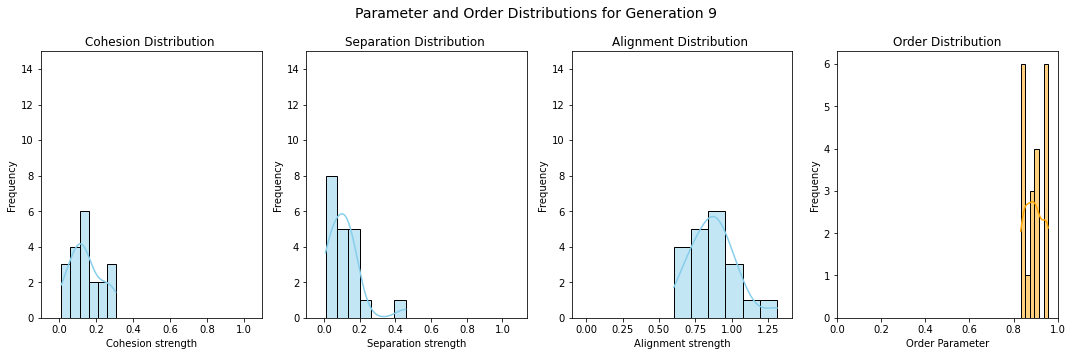

In [51]:
#Plot for several generations the marginals and fitness values
param_max = np.max(np.max(gener, axis=1),axis = 0) 
for generation in range(len(gener)):
    plot_marginal(generation, gener, order, param_max)
plt.show()

In [52]:
def analysis(set_params, num):
    """Run the experiment given specific params"""
    params = get_pars(write=False,
                      coh_strength=set_params[num][0],
                      sep_strength=set_params[num][1],
                      al_strength=set_params[num][2],
                       seed = np.random.randint(100, size=1)[0]
                      )
    orders, nns = run_experiment(params)
    return orders, nns

In [55]:
def runs_three(set_params, index_param, num_iter = 20):
    """Run the simulation for three sets of parameters 
    and plot the mean order parameters and the mean nns"""
    dist_orders_mult = []
    dist_nns_mult = []
    for iterations in range(num_iter):
        dist_orders, dist_nns = analysis(set_params, index_param)
        dist_orders_mult.append(dist_orders)
        dist_nns_mult.append(dist_nns)
    # Calculate mean and variance across runs for each step
    mean_values_orders = np.mean(dist_orders_mult, axis=0)
    variance_values_orders = np.var(dist_orders_mult, axis=0)

    mean_values_nns = np.nanmean(dist_nns_mult, axis=0)
    mean_mean_values_nns = np.mean(mean_values_nns, axis=1)
    variance_values_nns = np.var(mean_values_nns, axis=1)
    
    # Plot mean curve
    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    axs[0].plot(mean_values_orders, color='blue', label='Mean Order Parameter')
    axs[1].plot(mean_mean_values_nns, color='red', label='Mean Nearest Neighbor Distances')

    # Add shaded bands for boundaries based on variance
    axs[0].fill_between(range(300), mean_values_orders - np.sqrt(variance_values_orders), 
                        mean_values_orders + np.sqrt(variance_values_orders),
                    color='skyblue', alpha=0.3 , label=f'Variance Level {i}')
    
    axs[1].fill_between(range(300), mean_mean_values_nns - np.sqrt(variance_values_nns), 
                        mean_mean_values_nns + np.sqrt(variance_values_nns),
                    color='skyblue', alpha=0.3 , label=f'Variance Level {i}')

    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Order')
    axs[0].set_ylim([0, 1.0])
    axs[0].set_title(f'Mean Order for the {index_param +1} set of parameters')
    axs[0].grid(True)

    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('NN')
    axs[1].set_ylim(bottom= 0)
    axs[1].set_title(f'Mean NN for the {index_param +1} set of parameters')
    axs[1].grid(True)

    # Show plot
    fig.show()

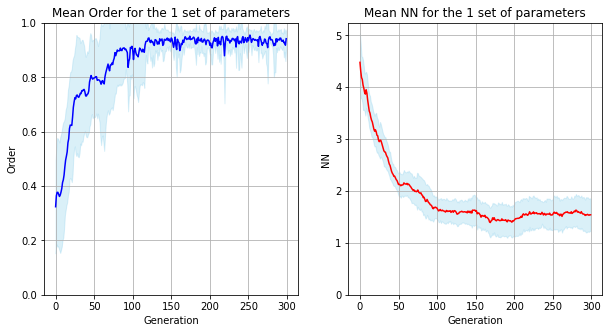

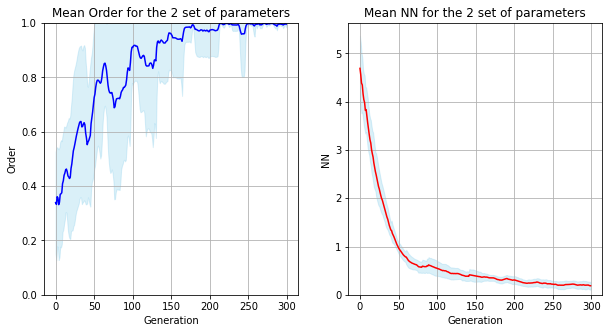

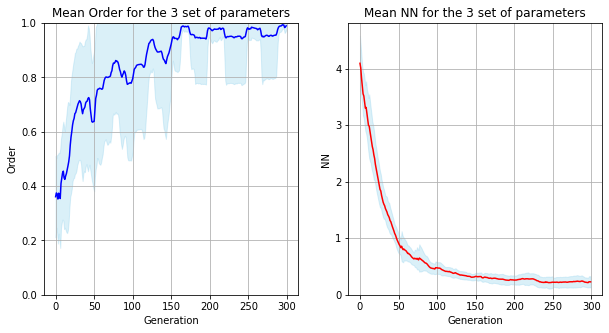

In [56]:
# Run the simulation for a set of 3 parameters and plot the mean order and the mean nearest-neighbour distance
three_sets = random.sample(gener[-1], 3)
for i in range(3):
    runs_three(three_sets, i)

## Run the simulation for alignment = 0.6

In [57]:
gener2, order2 = ABC(target = 0.6,iterations= 9, eps= 0.66)

generation = 1 #params = 20
generation = 2 #params = 20
generation = 3 #params = 20
generation = 4 #params = 20
generation = 5 #params = 20
generation = 6 #params = 20
generation = 7 #params = 20
generation = 8 #params = 20
generation = 9 #params = 20


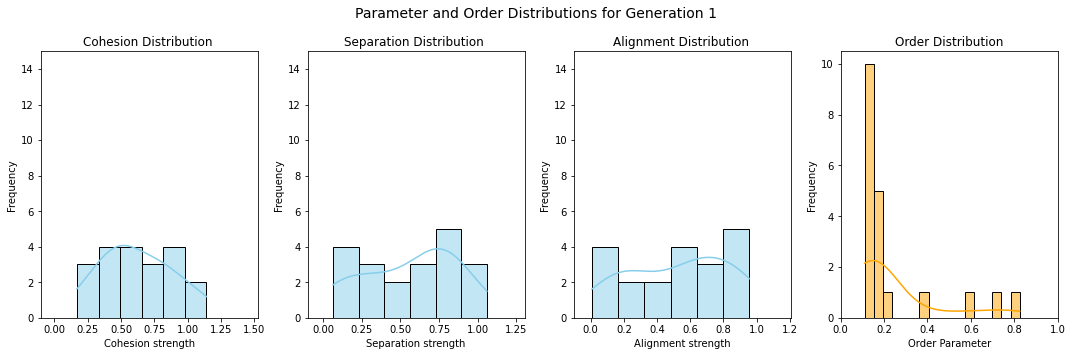

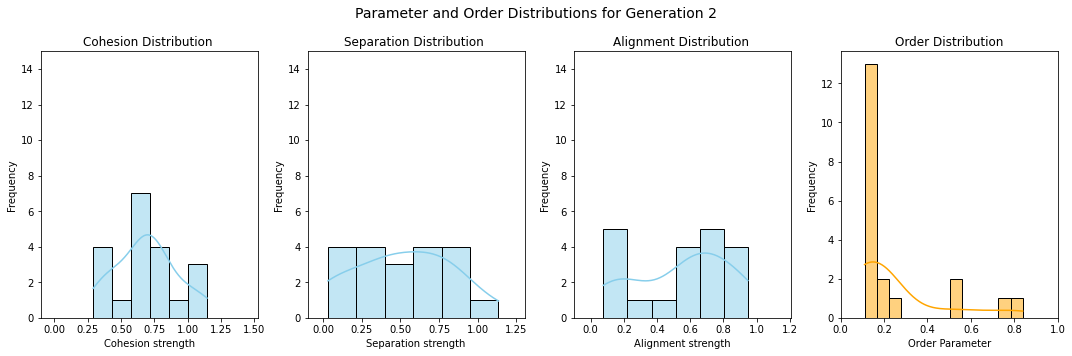

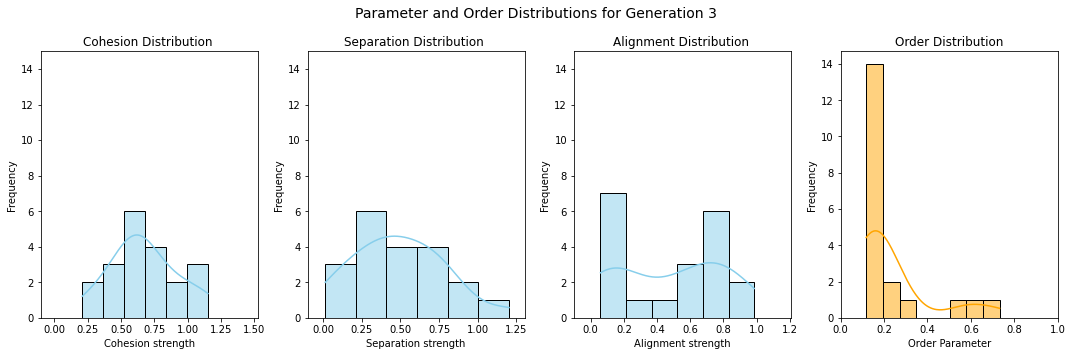

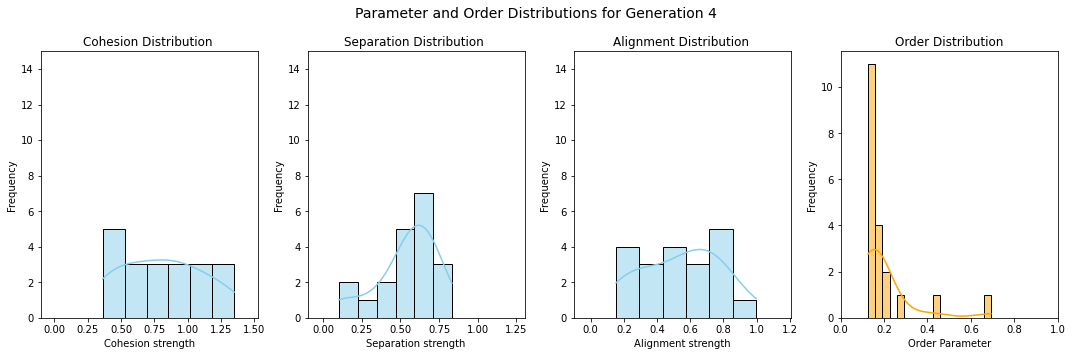

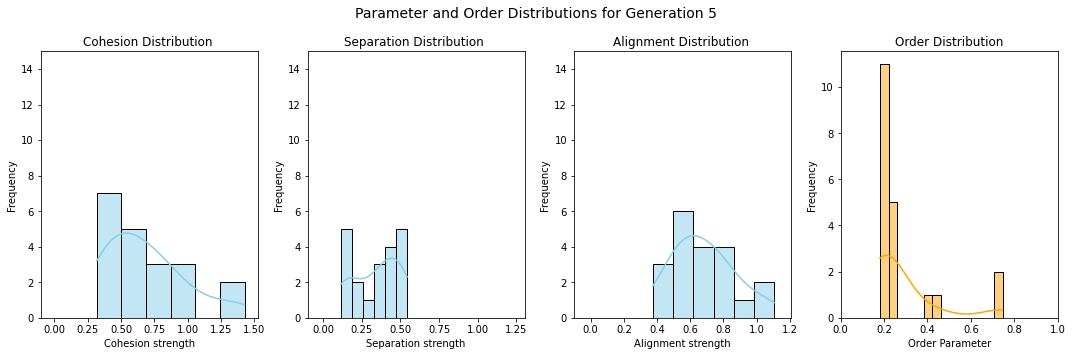

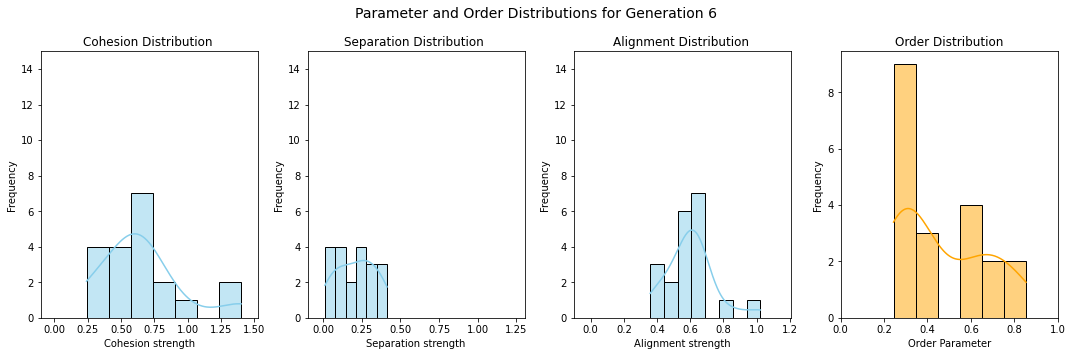

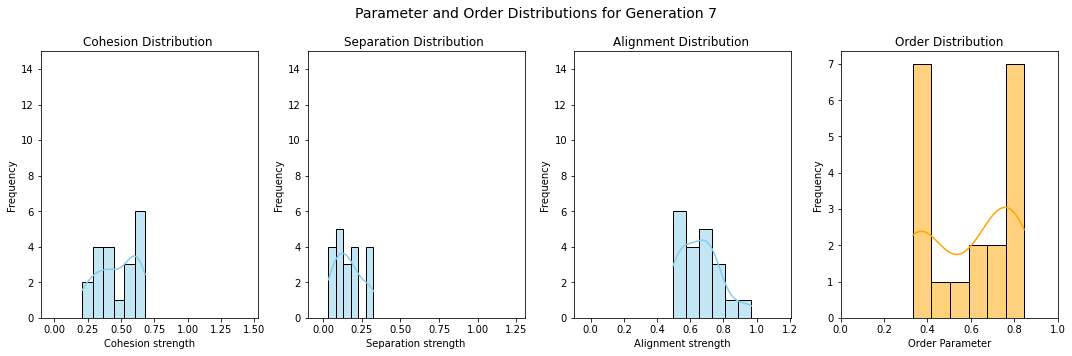

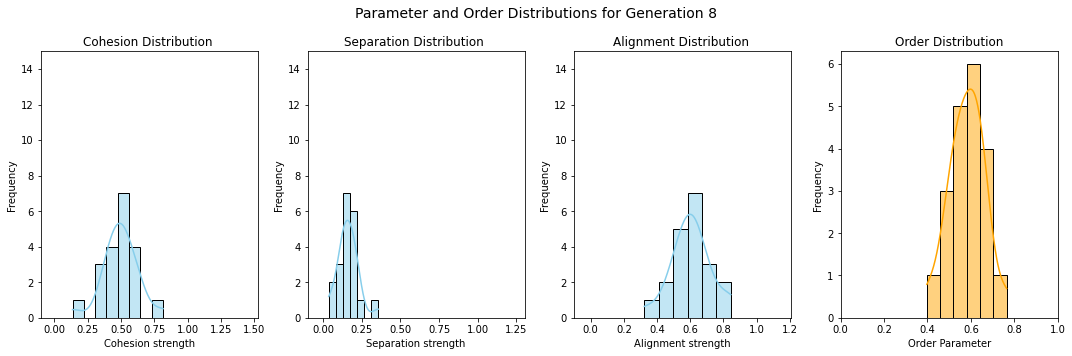

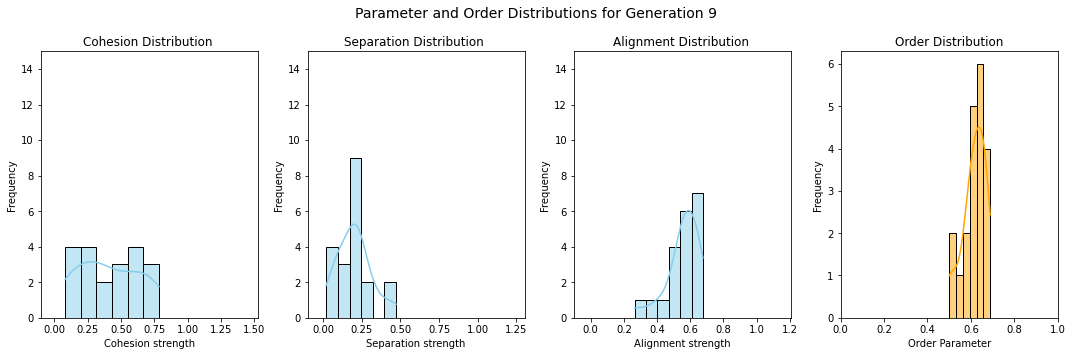

In [58]:
#Plot for several generations the marginals and fitness values
param_max = np.max(np.max(gener2, axis=1),axis = 0) 
for generation in range(len(gener2)):
    plot_marginal(generation, gener2, order2, param_max)
plt.show()

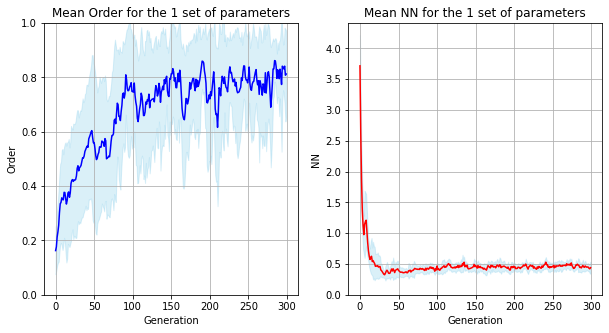

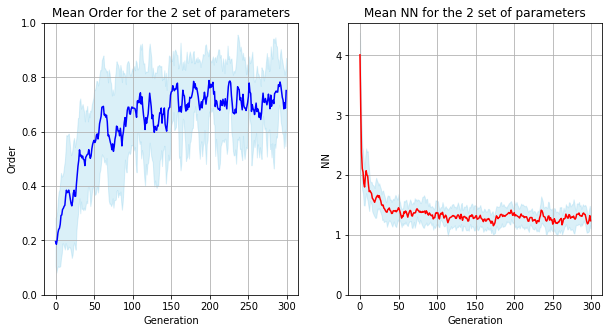

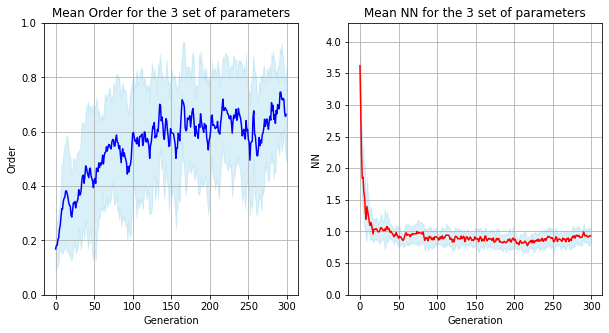

In [59]:
# Run the simulation for a set of 3 parameters and 
# plot the mean order and the mean nearest-neighbour distance
three_sets2 = random.sample(gener2[-1], 3)
for i in range(3):
    runs_three(three_sets2, i)

In [64]:
# Run the animation of the simulation for the last generation parameters randomly
params = random.choice(gener2[-1])
simulation_number = 20
par = get_pars(simulation_number=simulation_number, coh_strength= params[0], sep_strength=params[1], al_strength=params[2])
anim = animation_plot(BoidsModel, par)
IPython.display.HTML(anim.to_jshtml(fps=20))

Once 
 
 Loop 
 
 Reflect

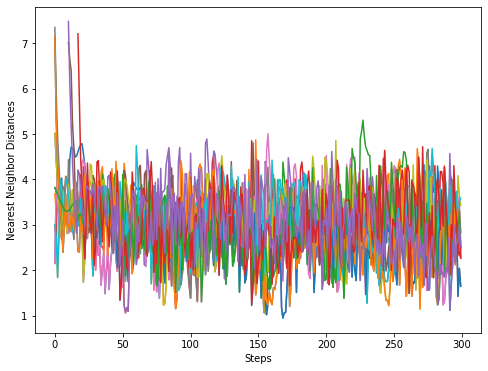

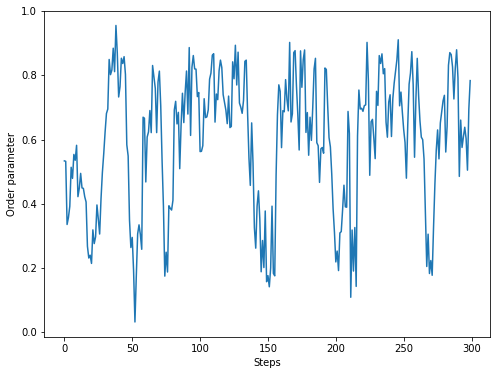

In [65]:
plot_simulation_nns_order(simulation_number)

In [66]:
print(params)

[0.08028362 0.40134945 0.67671054]
